In [9]:
import optuna

from KNNClassifier import KNNClassifier
from KMeans import KMeans
import DatasetRun
import Metrics

In [10]:
# in case of running the program on a remote server after converting it to .py
is_jupyter = DatasetRun.is_jupyter()

study_name = "dataset2_with_kmeans"
device = DatasetRun.get_device()

Device used: cuda


Sample run

In [11]:
if is_jupyter:
    metric = Metrics.MahalanobisMetric(shrinkage=True, gamma_1=1, gamma_2=1, normalization=True)
    metric_kmeans = Metrics.MahalanobisMetric(shrinkage=True, gamma_1=1, gamma_2=1, normalization=True)
    kmeans = KMeans(n_clusters=10, metric=metric_kmeans)
    clf = KNNClassifier(n_neighbors=3, metric=metric, is_normalization=True, tukey_lambda=0.5, kmeans=kmeans, device=device)
    _ = DatasetRun.train(clf=clf, folder_name='./data/tasks2', n_tasks=6, only_last=False, verbose=True)

task 0: (time: 10.722)
Paper accuracy: 83.560; My accuracy: 83.260
task 1: (time: 7.966)
Paper accuracy: 76.517; My accuracy: 75.400
task 2: (time: 9.349)
Paper accuracy: 72.129; My accuracy: 70.671
task 3: (time: 12.924)
Paper accuracy: 67.662; My accuracy: 65.900
task 4: (time: 17.367)
Paper accuracy: 64.533; My accuracy: 62.367
task 5: (time: 23.622)
Paper accuracy: 62.280; My accuracy: 60.400


## Grid search

In [12]:
def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 1, 250)
    n_neighbors = trial.suggest_int('n_neighbors', 1, min(50, n_clusters))
    gamma_1 = trial.suggest_float('gamma_1', 0.0001, 6., log=True)
    gamma_2 = trial.suggest_float('gamma_2', 0.0001, 6., log=True)
    tukey_lambda = trial.suggest_float('lambda', 0.0001, 3., log=True)
    
    metric = Metrics.MahalanobisMetric(shrinkage=True, gamma_1=gamma_1, gamma_2=gamma_2, normalization=True)
    kmeans = KMeans(n_clusters=n_clusters)
    clf = KNNClassifier(n_neighbors=n_neighbors, metric=metric, tukey_lambda=tukey_lambda, kmeans=kmeans, device=device)
    accuracy = DatasetRun.train(clf=clf, folder_name='./data/tasks2', n_tasks=6, only_last=True, verbose=False)
    
    return accuracy

DatasetRun.grid_search(objective=objective, 
                       study_name=study_name, 
                       n_trials=1, 
                       sampler=optuna.samplers.RandomSampler(),
                       restart=False, 
                       n_jobs=1, 
                       verbose=4)
DatasetRun.save_to_csv(study_name)

[I 2024-10-07 00:37:26,208] Using an existing study with name 'dataset2_with_kmeans' instead of creating a new one.
[I 2024-10-07 00:39:28,544] Trial 7022 finished with value: 34.8 and parameters: {'n_clusters': 81, 'n_neighbors': 49, 'gamma_1': 5.30428086974472, 'gamma_2': 0.04373387821571713, 'lambda': 0.004824852683535265}. Best is trial 4368 with value: 62.470000000000006.


Best hyperparameters:  {'n_clusters': 1, 'n_neighbors': 1, 'gamma_1': 2.4614447279542473, 'gamma_2': 3.218644019546994, 'lambda': 0.35339307901428485}
Best accuracy:  62.470000000000006


plot accuracy over trials (to check how well did the grid search work)

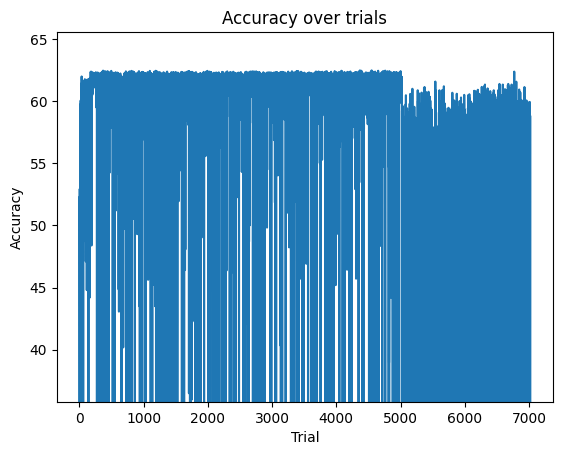

In [13]:
if is_jupyter:
    DatasetRun.plot_accuracy_trials(study_name=study_name, ylim=True)

plot accuracies against hyperparameters' values 

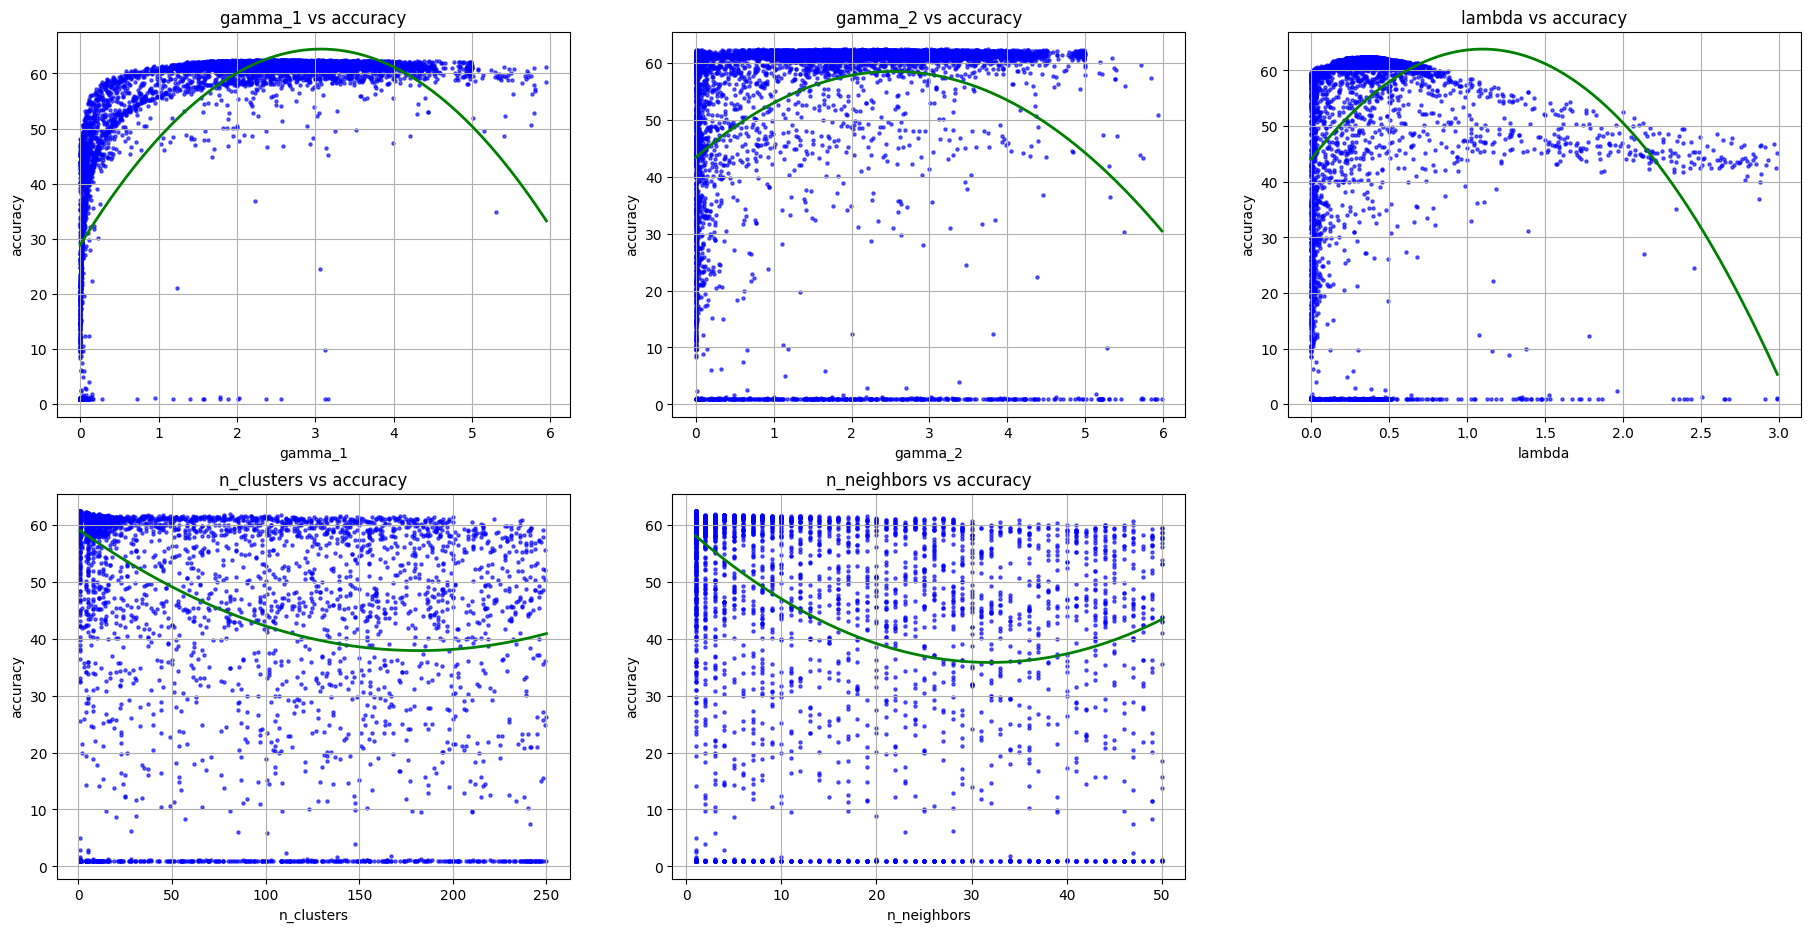

In [16]:
if is_jupyter:
    DatasetRun.plot_hyperparameters(study_name, columns=3, deg=2, ylim=False)

In [15]:
if is_jupyter:
    display(DatasetRun.print_results(study_name, only_important=True))

,value,gamma_1,gamma_2,lambda,n_clusters,n_neighbors
4550,62.47,2.509727,2.033876,0.357363,1,1
4368,62.47,2.461445,3.218644,0.353393,1,1
4761,62.45,2.569796,2.442552,0.358584,1,1
368,62.45,2.239839,2.328365,0.382294,1,1
4079,62.44,2.485359,1.888474,0.361933,1,1
...,...,...,...,...,...,...
5721,0.97,0.101012,3.847023,0.191061,201,49
5262,0.96,0.010884,1.276744,0.631046,162,38
5459,0.96,0.003876,5.894305,0.000534,47,8
2006,0.93,0.047789,2.016837,0.239212,1,1
